In [18]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

img1 = cv.imread('./data/Statue1.bmp',0)  #queryimage # left image
img2 = cv.imread('./data/Statue2.bmp',0) #trainimage # right image

sift = cv.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher(cv.NORM_L2)

# For each local descriptor des1, find 2 best correspondence from des 2
matches = bf.knnMatch(des1, des2, k=2)  # Think of it just finding a cluster of ssd.

In [3]:
good = []
pts1 = []
pts2 = []

mask = [[0,0]] * len(matches)

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        mask[i] = [1,0]


pts1 = np.int32(pts1)
pts2 = np.int32(pts2)


F, mask_F = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC, param1=3)
E, mask_E = cv.findEssentialMat(pts1, pts2)
print(F)

# We select only inlier points
pts1 = pts1[mask_F.ravel()==1]
pts2 = pts2[mask_F.ravel()==1]


[[ 4.09985571e-07 -4.68922150e-06  1.04274307e-03]
 [ 3.99712089e-06  7.92728443e-07 -2.77626198e-02]
 [-3.50962653e-03  2.79694329e-02  1.00000000e+00]]


In [4]:


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

[[-4.2726636e-02  9.9908680e-01 -5.2489960e+02]
 [-4.4135619e-02  9.9902552e-01 -5.1529120e+02]
 [-4.4135619e-02  9.9902552e-01 -5.1529120e+02]
 ...
 [-3.3323452e-02  9.9944460e-01 -5.8898181e+02]
 [-3.5366677e-02  9.9937439e-01 -5.7506348e+02]
 [ 6.8644602e-03  9.9997646e-01 -8.6204712e+02]]


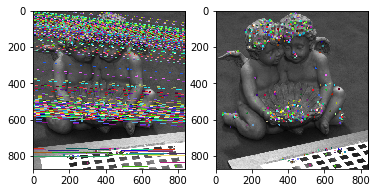

In [5]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)

print(lines1)

img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)


fig = plt.figure()
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img6)

plt.show()

In [6]:
# Input Intrinsic Matrix
# K = np.array([[1.4219, 0.0005, 0.5092],[0, 1.4219, 0.3802],[0,0,0.0010]])
K1 = np.array([[5426.566895, 0.678017, 330.096680],[0.000000, 5423.133301, 648.950012],[0,0,1]])
K2 = np.array([[5426.566895, 0.678017, 387.430023], [0.000000, 5423.133301,620.616699] , [0,0,1]])

# Compute Essential Matrix from Fundamental Matrix and Intrinsic Matrix
E = np.dot(K1.transpose(), np.dot(F, K2))

def decomposeEssentialMatrix(E):    
    R1,R2,u3 = cv.decomposeEssentialMat(E)
    u3 = u3.transpose()
    return [np.vstack((R1.transpose(), u3)).transpose(), 
            np.vstack((R1.transpose(), -u3)).transpose(),
            np.vstack((R2.transpose(), u3)).transpose(),
            np.vstack((R2.transpose(), -u3)).transpose()]

all_p2_solutions = decomposeEssentialMatrix(E)

In [7]:
p1 = np.vstack((np.eye(3), np.zeros(3))).transpose()
p2 = all_p2_solutions[0] # just take one as an example
print(p1)
print(p2)

def getRmatAndTmat(p):
    R= p1[:, :3];t = p1[:, 3];
    return R, t

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[[ 0.10932663 -0.08224898  0.99059719  0.7221035 ]
 [ 0.03953397 -0.99542245 -0.08701276 -0.04927185]
 [ 0.99321939  0.04867505 -0.10557455  0.69002813]]


(400, 3)


<IPython.core.display.Javascript object>


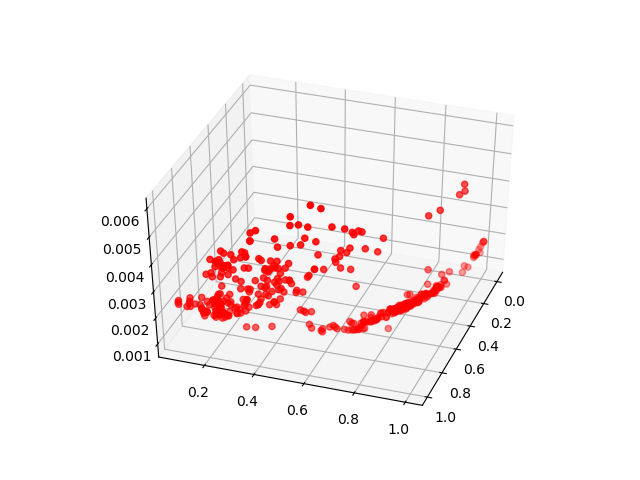

In [40]:
def triangulatePoint(point_1, point_2, p1, p2):
    # define A
    u1, v1 = point_1[0], point_1[1]
    u2, v2 = point_2[0], point_2[1]
    
    A= np.zeros((4,4))
    
    A[0] = u1*p1[2] - p1[0]
    A[1] = v1*p1[2] - p1[1]
    A[2] = u2*p2[2] - p2[0]
    A[3] = v2*p2[2] - p2[1]
    
    u,s,v = np.linalg.svd(A)
    x = v[-1]
    return x

def triangulate(pts1, pts2, p1, p2):
    R1,t1 = getRmatAndTmat(p1)
    R2,t2 = getRmatAndTmat(p2)
    
    # compute camera centers
    C1 = -np.dot(R1.transpose(), t1)
    C2 = -np.dot(R2.transpose(), t2)
    
    V1 = np.dot(R1.transpose(), np.array([0,0,1]))
    V2 = np.dot(R2.transpose(), np.array([0,0,1]))
    
    points = []
    for pt1, pt2 in zip(pts1, pts2):
        point_in_3d = triangulatePoint(pt1, pt2, p1, p2)[:3]
        test1 = np.dot((point_in_3d-C1),V1)
        test2 = np.dot((point_in_3d-C2),V2)
        if (test1 > 0 and test2 > 0):
            points.append(point_in_3d)
            
    return np.array(points)


# print(triangulatePoint(pts1[0,:2], pts2[0,:2], p1, p2))

# points = cv.triangulatePoints(p1, p2, pts1[0:5].transpose(), pts2.transpose())
# print(points)
%matplotlib notebook
points = triangulate(pts1, pts2, p1, all_p2_solutions[3])
print(points.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c='r', marker='o')
